In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict

ACTIONS = {
    "U": (0, 1),
    "D": (0, -1),
    "L": (-1, 0),
    "R": (1, 0),
}


class GridQLearning:
    def __init__(self, grid_size: tuple[int, int], start_state: tuple[int, int], terminal_state: tuple[int, int], 
                 alpha: float, gamma: float, epsilon: float, beta: float, episodes: int, max_steps_per_episode: int = 100):
        self.grid_size = grid_size
        self.actions = ACTIONS
        self.all_states = [(r, c) for r in range(grid_size[0]) for c in range(grid_size[1])]
        self.start_state = start_state
        self.terminal_state = terminal_state
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.beta = beta
        self.episodes = episodes
        self.max_steps_per_episode = max_steps_per_episode
        self.Q = defaultdict(float)
        self.t = 0
        
        # Storage for progression
        self.episode_records = []
        self.steps_per_episode = []
    
    def in_bounds(self, state):
        """Check if state is within grid bounds."""
        r, c = state
        return 0 <= r < self.grid_size[0] and 0 <= c < self.grid_size[1]

    def step(self, state: tuple[int, int], action: str):
        """Environment transition: move in grid with boundary clipping; reward 1 at terminal, else 0."""
        if state == self.terminal_state:
            return state, 0.0, True
        
        dr, dc = self.actions[action]
        r, c = state
        nr, nc = r + dr, c + dc
        
        # clip to bounds
        if not self.in_bounds((nr, nc)):
            nr, nc = r, c
        
        s_next = (nr, nc)
        rwd = 1.0 if s_next == self.terminal_state else 0.0
        done = s_next == self.terminal_state
        return s_next, rwd, done

    def epsilon_greedy_action(self, state):
        """ε-greedy over available actions (all actions valid; out-of-bounds stay put)."""
        if state == self.terminal_state:
            return None
        
        eps = self.epsilon * np.exp(-self.beta * self.t)

        if np.random.rand() < eps:
            action = np.random.choice(list(self.actions.keys()))
        else:
            # exploit: argmax with random tie-break among best
            qvals = {a: self.Q[(state, a)] for a in self.actions}
            max_q = max(qvals.values())
            best = [a for a, q in qvals.items() if q == max_q]
            action = np.random.choice(best)
        self.t += 1
        return action

    def train(self):
        """Train the Q-learning agent."""
        for ep in range(1, self.episodes + 1):
            s = self.start_state
            steps = 0
            
            for t in range(self.max_steps_per_episode):
                a = self.epsilon_greedy_action(s)
                if a is None:
                    break
                
                s_next, rwd, done = self.step(s, a)
                
                # Q-update
                if s_next == self.terminal_state:
                    max_next = 0.0
                else:
                    max_next = max(self.Q[(s_next, a2)] for a2 in self.actions)
                
                target = rwd + self.gamma * max_next
                self.Q[(s, a)] = self.Q[(s, a)] + self.alpha * (target - self.Q[(s, a)]) # update Q-value
                
                s = s_next
                steps += 1
                
                if done:
                    break
            
            self.steps_per_episode.append(steps)

            # Record full Q-table snapshot after this episode
            rec = {"Episode": ep}
            for state in self.all_states:
                for a in self.actions:
                    rec[f"Q{state},{a}"] = self.Q[(state, a)]
            self.episode_records.append(rec)

    def plot_results(self):
        """Plot training results."""
        # Build DataFrame (episodes × (states×actions))
        df = pd.DataFrame(self.episode_records).set_index("Episode")

        # Display the large table for users to inspect/filter
        print("3x3 Gridworld Q(s,a) by Episode (ε-greedy)")
        print(df)

        # Plot 1: All Q(s,a) curves over episodes
        plt.figure(figsize=(9, 6))
        for col in df.columns:
            plt.plot(df.index, df[col], label=col)
        plt.xlabel("Episode")
        plt.ylabel("Q-value")
        plt.title(f"All Q(s,a) over Episodes ({self.grid_size[0]}x{self.grid_size[1]} grid, {self.epsilon}-greedy)")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Plot 2: Steps taken each episode
        plt.figure(figsize=(8, 4.5))
        plt.plot(range(1, self.episodes + 1), self.steps_per_episode, marker="o")
        plt.xlabel("Episode")
        plt.ylabel("Steps in episode")
        plt.title("Episode Length (steps) over Training")
        plt.tight_layout()
        plt.show()

    def greedy_policy_from_Q(self):
        """Derive the greedy policy from final Q values."""
        policy = {}
        for s in self.all_states:
            if s == self.terminal_state:
                policy[s] = None
                continue
            qvals = {a: self.Q[(s, a)] for a in self.actions}
            max_q = max(qvals.values())
            best = [a for a, q in qvals.items() if q == max_q]
            policy[s] = np.random.choice(best)
        return policy

    def simulate_greedy_episode(self):
        """Simulate one greedy episode from start to show the path found."""
        policy = self.greedy_policy_from_Q()
        path = [self.start_state]
        s = self.start_state
        
        for _ in range(20):
            if s == self.terminal_state:
                break
            a = policy[s]
            s, _, _ = self.step(s, a)
            path.append(s)
        
        return path

    def get_final_results(self):
        """Get final Q-table and policy results."""
        policy = self.greedy_policy_from_Q()
        
        # Prepare a compact table of final Qs and the final greedy policy for quick reference
        final_Q_table = []
        for s in self.all_states:
            row = {"state": s}
            for a in self.actions:
                row[a] = self.Q[(s, a)]
            row["greedy_action"] = policy[s]
            final_Q_table.append(row)

        df_final = pd.DataFrame(final_Q_table)
        print("Final Q-values and Policy:")
        print(df_final)
        
        # Get the discovered greedy path
        path = self.simulate_greedy_episode()
        print(f"Greedy path from start to terminal: {path}")
        
        return df_final, path


3x3 Gridworld Q(s,a) by Episode (ε-greedy)
         Q(0, 0),U  Q(0, 0),D  Q(0, 0),L  Q(0, 0),R  Q(0, 1),U  Q(0, 1),D  \
Episode                                                                     
1          0.00000        0.0   0.000000   0.000000        0.0        0.0   
2          0.00000        0.0   0.000000   0.000000        0.0        0.0   
3          0.00000        0.0   0.000000   0.000000        0.0        0.0   
4          0.00000        0.0   0.000000   0.000000        0.0        0.0   
5          0.00000        0.0   0.000000   0.000000        0.0        0.0   
6          0.00000        0.0   0.000000   0.387420        0.0        0.0   
7          0.00000        0.0   0.000000   0.593528        0.0        0.0   
8          0.00000        0.0   0.000000   0.644590        0.0        0.0   
9          0.00000        0.0   0.000000   0.654237        0.0        0.0   
10         0.00000        0.0   0.000000   0.655822        0.0        0.0   
11         0.00000        0.0   0

/var/folders/gd/yqjzn9wx32z1wh0n8phrb9d40000gn/T/ipykernel_32415/1526850805.py:131: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


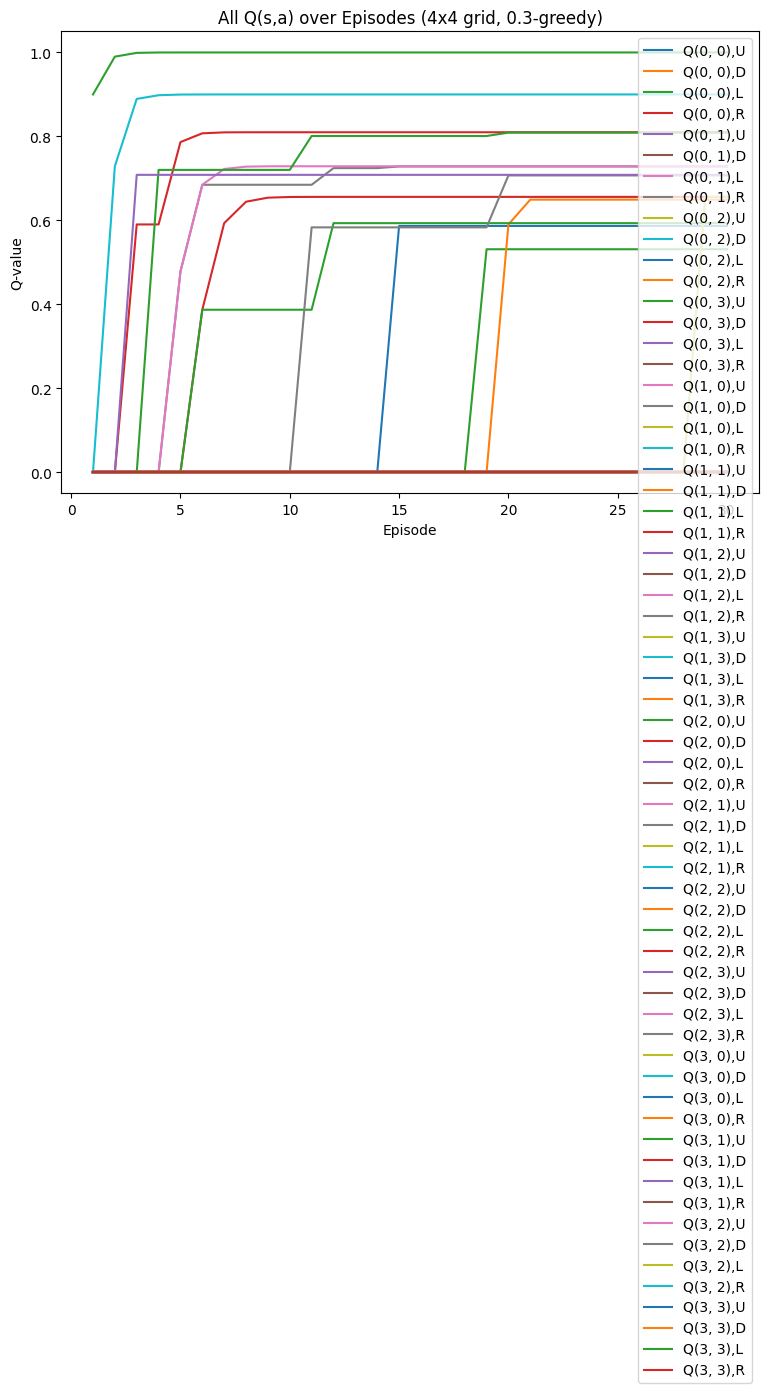

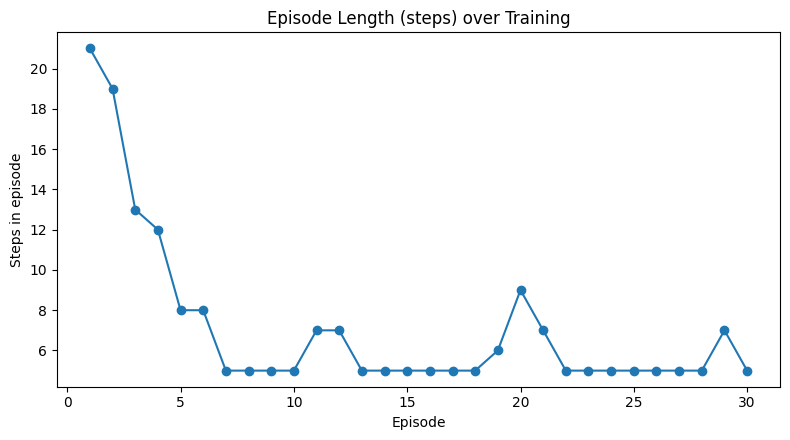

Final Q-values and Policy:
     state         U         D         L         R greedy_action
0   (0, 0)  0.586920  0.000000  0.531441  0.656100             R
1   (0, 1)  0.000000  0.000000  0.000000  0.728559             R
2   (0, 2)  0.000000  0.000000  0.000000  0.000000             U
3   (0, 3)  0.000000  0.000000  0.000000  0.000000             L
4   (1, 0)  0.729000  0.000000  0.000000  0.000000             U
5   (1, 1)  0.000000  0.649539  0.593528  0.810000             R
6   (1, 2)  0.000000  0.000000  0.000000  0.000000             D
7   (1, 3)  0.000000  0.000000  0.000000  0.000000             L
8   (2, 0)  0.809104  0.000000  0.000000  0.000000             U
9   (2, 1)  0.000000  0.707194  0.656100  0.900000             R
10  (2, 2)  0.000000  0.000000  0.000000  0.000000             U
11  (2, 3)  0.000000  0.000000  0.000000  0.000000             D
12  (3, 0)  0.000000  0.000000  0.000000  0.000000             D
13  (3, 1)  1.000000  0.000000  0.708588  0.000000             

In [2]:
if __name__ == "__main__":
    # np.random.seed(42)  # for reproducibility

    GRID_SIZE = (4, 4)  # rows, cols
    alpha = 0.9
    gamma = 0.9
    epsilon = 0.3  # exploration rate
    beta = 0.01  # decay rate for epsilon
    episodes = 30
    start_state = (0, 0)
    terminal_state = (3, 2)
    max_steps_per_episode = 100

    agent = GridQLearning(GRID_SIZE,start_state,terminal_state,alpha,gamma,epsilon,beta,episodes,max_steps_per_episode)
    agent.train()
    agent.plot_results()

    df_final, path = agent.get_final_results()
